# Yeast Polarisome
***
The polarisome is a orgranelle at the tip of the mating projction in budding yeast.  This notebook shows results from the model published by Lawson et al. PloS Computational Biology (2013).  http://www.ploscompbiol.org/article/info%3Adoi%2F10.1371%2Fjournal.pcbi.1003139
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import math
import numpy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

In [4]:
import spatialpy

***
## Create the Data Functions for the System
***

In [5]:
class Cdc42(spatialpy.DataFunction):
    def __init__(self, a=-4 * numpy.pi, b=4 * numpy.pi, N=160):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="Cdc42")
        self.a = a
        self.b = b
        self.N = N

    def expression(self):
        Gradient_max = 3.0 * 160 / self.N
        Gradient_max = Gradient_max * 0.7917
        Gradient_sigma = 20.3837
        numer = f"-1 * pow((me->x[0] * 360 / ({self.b - self.a})), 2)"
        denom = f"{2 * Gradient_sigma**2}"
        return f"100 * {Gradient_max} * exp({numer} / {denom})"

    def map(self, x):  #for vizulization
        Gradient_max = 3.0 * 160 / self.N
        Gradient_max = Gradient_max * 0.7917
        Gradient_sigma = 20.3837
        return 100 * Gradient_max * numpy.exp( 
                -1 * ((x[0] * 360 / (self.b - self.a))**2) / (2 * Gradient_sigma**2)
            )

***
## Create the Polarisome 1D Model
***

In [6]:
def create_polarisome_1D(model_name="polarisome_1D", parameter_values=None):
    # Initialize Model
    model = spatialpy.Model(model_name)
    
    # System constants
    default_D = 0.0053
    fast_D = 1000 * default_D
    NUM_VOXELS = 160

    # Define Domain
    domain = spatialpy.Domain.create_2D_domain(
        ny=1, nx=NUM_VOXELS, xlim=(-4 * numpy.pi, 4 * numpy.pi), ylim=(0,1)
    )
    
    # Set Models Domain
    model.add_domain(domain)

    # Define Variables (SpatialPy.Species)
    Bni1c = spatialpy.Species(name="Bni1c",  diffusion_coefficient=fast_D)
    Bni1m = spatialpy.Species(name="Bni1m",  diffusion_coefficient=default_D)
    Spa2c = spatialpy.Species(name="Spa2c",  diffusion_coefficient=fast_D)
    Spa2m = spatialpy.Species(name="Spa2m",  diffusion_coefficient=default_D)
    Actinc = spatialpy.Species(name="Actinc",  diffusion_coefficient=fast_D)
    Actinm = spatialpy.Species(name="Actinm",  diffusion_coefficient=default_D)
    
    # Add Variables to Model
    model.add_species([Bni1c, Bni1m, Spa2c, Spa2m, Actinc, Actinm])

    # Define Initial Conditions
    # Distribute molecules randomly over the mesh according to their initial values
    Bni1c_ic = spatialpy.ScatterInitialCondition(Bni1c, 1000)
    Spa2c_ic = spatialpy.ScatterInitialCondition(Spa2c, 5000)
    Actinc_ic = spatialpy.ScatterInitialCondition(Actinc, 40)
    
    # Add Initial Conditions to Model
    model.add_initial_condition([Bni1c_ic, Spa2c_ic, Actinc_ic])

    # Define Parameters
    Bon = spatialpy.Parameter(name="Bon", expression=1.6e-6)
    Boff = spatialpy.Parameter(name="Boff", expression=0.25)
    Bfb = spatialpy.Parameter(name="Bfb", expression=1.9e-5)
    Aon = spatialpy.Parameter(name="Aon", expression=7.7e-5)
    Aoff = spatialpy.Parameter(name="Aoff", expression=0.018)
    Km = spatialpy.Parameter(name="Km", expression=3500)
    Son = spatialpy.Parameter(name="Son", expression=0.16)
    Soff = spatialpy.Parameter(name="Soff", expression=0.35)
    
    # Add Parameters to Model
    model.add_parameter([Bon, Boff, Bfb, Aon, Aoff, Km, Son, Soff]) 

    # Define Reactions
    R0 = spatialpy.Reaction(
        name="R0", reactants={'Bni1c': 1}, products={'Bni1m': 1},
        propensity_function=f"Bon * Bni1c * {NUM_VOXELS} * Cdc42"
    )
    R1 = spatialpy.Reaction(name="R1", reactants={'Bni1m': 1}, products={'Bni1c': 1}, rate='Boff')
    R2 = spatialpy.Reaction(
        name="R2", reactants={'Actinc': 1}, products={'Actinm': 1}, 
        propensity_function=f"Aon * Bni1m * Actinc * {NUM_VOXELS}"
    )
    R3 = spatialpy.Reaction(
        name="R3", reactants={'Actinm': 1}, products={'Actinc': 1}, 
        propensity_function="Aoff * Km / (Km + Spa2m) * Actinm"
    )
    R4 = spatialpy.Reaction(
        name="R4", reactants={'Spa2c': 1}, products={'Spa2m': 1}, 
        propensity_function=f"Son * Spa2c * {NUM_VOXELS} * Actinm"
    )
    R5 = spatialpy.Reaction(name="R5", reactants={'Spa2m': 1}, products={'Spa2c':1 }, rate='Soff')
    R6 = spatialpy.Reaction(
        name="R6", reactants={'Bni1c': 1}, products={'Bni1m': 1}, 
        propensity_function=f"Bfb * Bni1c * {NUM_VOXELS} * Spa2m"
    )
    
    # Add Reactions to Model
    model.add_reaction([R0, R1, R2, R3, R4, R5, R6])

    # Define Data Functions
    # mating pheromone gradient
    cdc42 = Cdc42()
    
    # Add Data Function to Model
    model.add_data_function(cdc42)

    # Define Timespan
    tspan = spatialpy.TimeSpan(range(0, 201, 10), timestep_size=1)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Instantiate the Model

In [7]:
model = create_polarisome_1D()

***
## Run the Simulation
***

In [8]:
%time result = model.run()

CPU times: user 38.8 ms, sys: 8.28 ms, total: 47.1 ms
Wall time: 14min 37s


***
## Visualizations
***

In [9]:
def plot(sname):
    x_vals = model.domain.coordinates()[:,0]
    
    tspan_len = len(model.tspan)
    num_rows = math.ceil(tspan_len/2)
    fig, axs = plt.subplots(num_rows, 2, figsize=[15, 6 * num_rows])
    if tspan_len%2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])
    
    for n, t in enumerate(model.tspan):
        S = result.get_species(sname, timepoints=n)
        axs[int(n/2), n%2].plot(x_vals, S)
        axs[int(n/2), n%2].set_title(f'{t}   t={sname}')

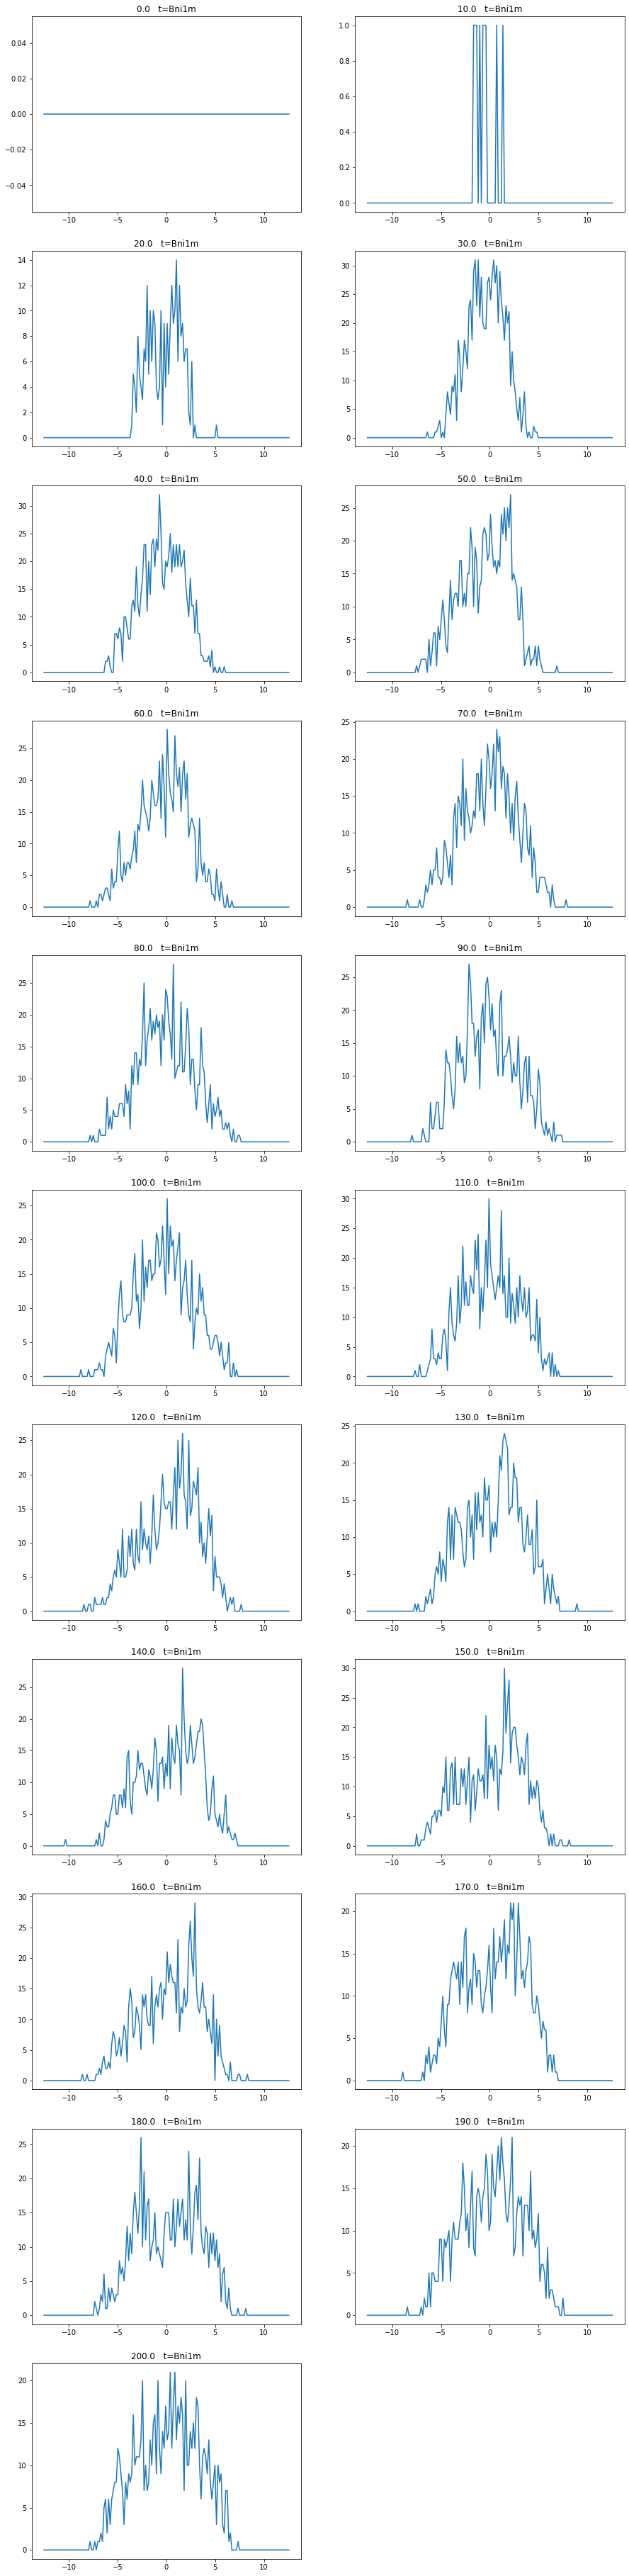

In [10]:
plot("Bni1m")

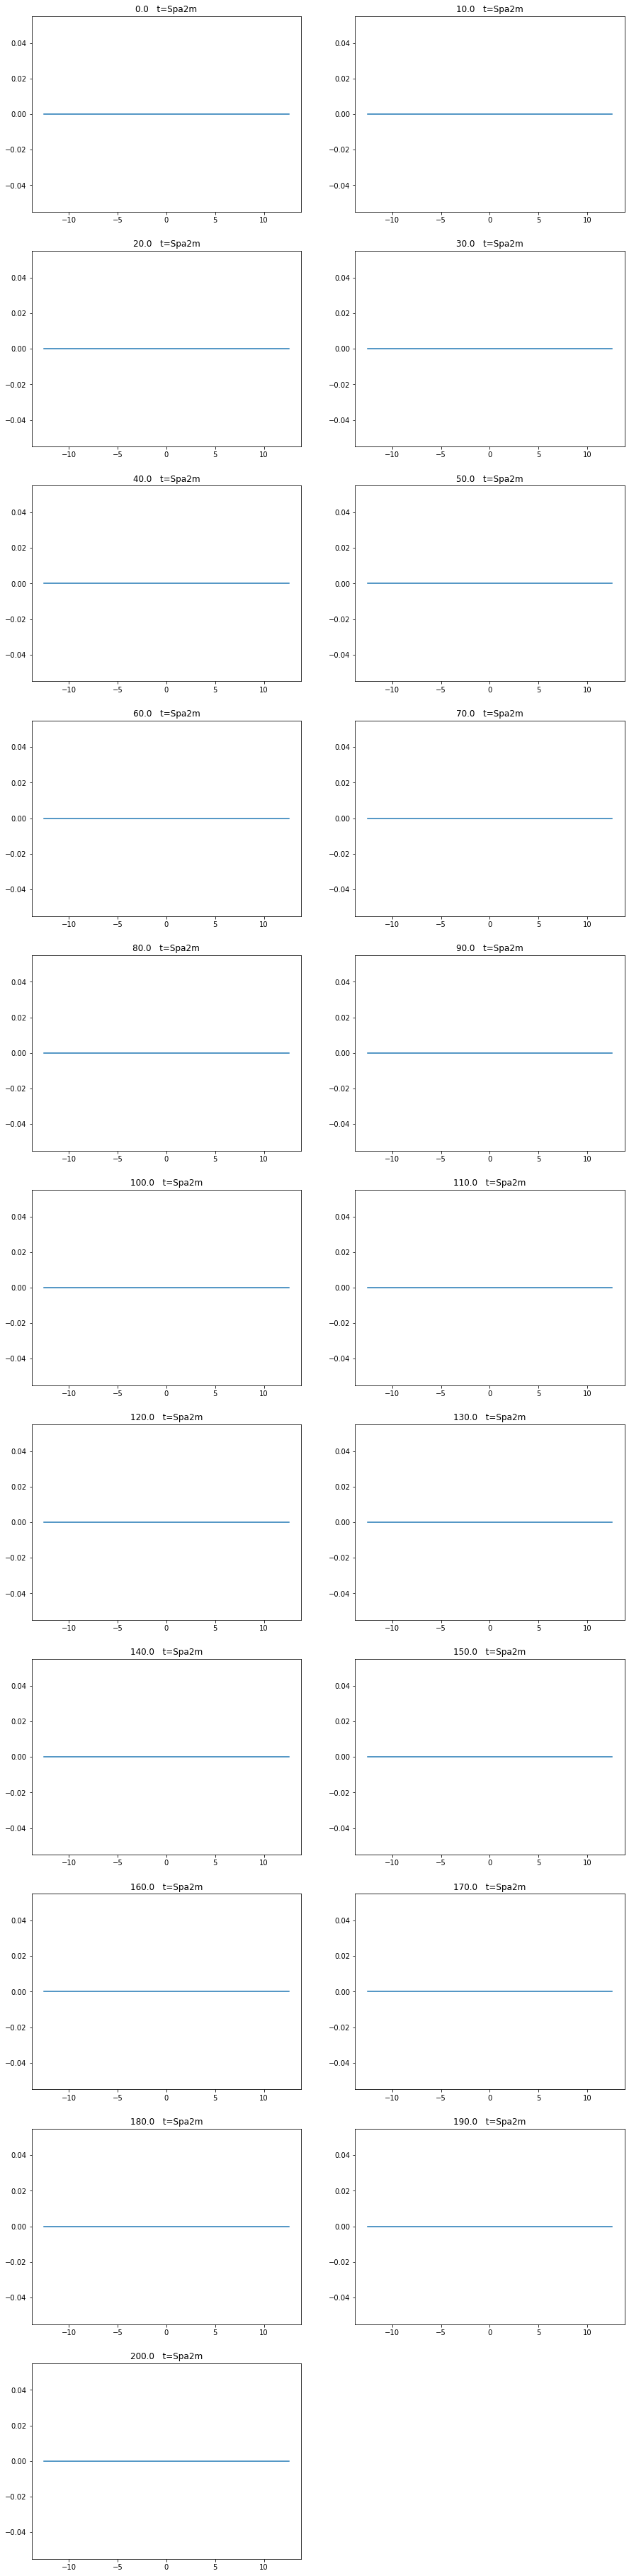

In [11]:
plot("Spa2m")

Text(0.5, 1.0, 'Input: Gradient of Cdc42')

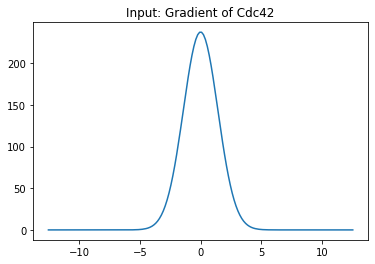

In [12]:
x_vals = model.domain.coordinates()[:, 0]
pg = Cdc42()
gradient = [pg.map([x]) for x in x_vals]
plt.plot(x_vals, gradient)
plt.title('Input: Gradient of Cdc42')